# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# 강력한 하나의 모델을 사용하는대신 보다 약한 모델 여러개를 조합하여 더 정확한 예측에 도움을 주는 방식(집단 지성)

# 예) 훈련 셋으로부터 무작위로 각기 다른 서브셋을 만듦 -> 각각의 결정 트리 분류기를 훈련시킴
# -> 예측을 할 땐 모든 개별 트리의 예측을 구해서 가장 많은 선택을 받은 클래스를 예측으로 삼음

# 결정트리의 앙상블을 랜덤 포레스트라고 함

# 프로젝트에 마지막에 다다르면 흔히 앙상블 방법을 사용해 이미 만든 여러 괜찮은 예측기를 연결하여 더 좋은 예측기를 만듦

# 7.1 투표 기반 분류기

In [3]:
# 예) 정확도가 80%인 분류기 여러 개를 훈련시킴 -> 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등을 가지고 있음
# 더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것
# 이렇게 다수결 투표로 정해지는 분류기를 '직접 투표(hard voting)' 분류기라고 함

# 이 다수결 투표 분류기는 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높은 경우가 많음
# 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음

In [4]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


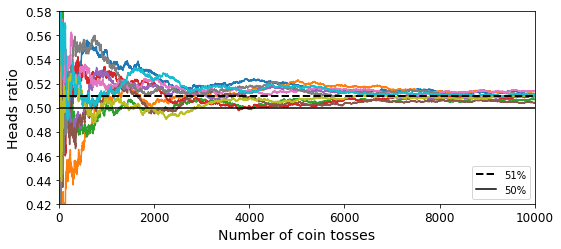

In [5]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

# 동전을 던졌을 때 앞면이 51%, 뒷면이 49%가 나오는 동전
# 1000번을 던졌을 때 대략 앞면이 510번, 뒷면이 490번 나오겠지 -> 1000번 던졌을 때 앞면이 다수가 될 확률은 75%에 가까움(아래 코드)
# 10000번 던지면 97% 이상임 -> 큰 수의 법칙(law of large numbers)

# 아래 그래프: 동전을 자꾸 던질수록 앞면이 나오는 비율은 점점 더 앞면이 나올 확률(51%)에 가까워짐(이러한 테스트를 10번 한 그래프임)

In [6]:
def fac(a):
    ans = 1
    for i in range(1, a+1):
        ans *= i
    return ans

def com(a, b):
    return fac(a) // (fac(b) * fac(a-b))

ans = 0
for i in range(500, 1001):
    ans += com(1000, i) * ((0.51)**i) * ((0.49)**(1000-i))
print(ans)

0.746750227556325


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# 위 예시의 의미: 51% 정확도를 가진 1000개의 분류기로 앙상블 모델을 구축 -> 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있음
# 하지만 이는 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 간으함 -> 하지만 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않음
# 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아짐

# 다시 말해 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘함

# 아래 코드는 moons 데이터셋을 훈련 셋으로 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기를 만들고 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') # hard voting

In [9]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [10]:
# 각 분류기의 테스트셋 정확도
from sklearn.metrics import accuracy_score
print('---hard voting---')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음!

---hard voting---
LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.888


In [11]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft') # soft voting
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [12]:
from sklearn.metrics import accuracy_score
print('---soft voting---')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음 -> '간접 투표(soft voting)'
# 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음

---soft voting---
LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 7.2 배깅(bagging, bootstrap aggregating)과 페이스팅(pasting)

### 배깅
- 훈련 셋에서 중복을 허용하여 샘플링하는 방식
- 각 데이터셋은 복원 추출(sampling with replacement)을 통해
- 원래 데이터의 수만큼의 크기를 갖도록 샘플링 (통계학에서는 중복을 허용한 리샘플링(resampling)을 부트스트래핑(bootstrapping)이라고 함)
- 예) original data set = [1,2,3,4,5], bootstrap1 = [3,2,2,3,5], bootstrap2 = [4,1,1,3,2] -> bootstrap1에는 1과 4가 없고 2와 3이 두 개씩 들어있음, 그리고 원래 데이터 셋의 크기가 5이기 때문에 bootstrap의 크기도 5

- 이렇게 샘플링한 뒤 bootstrap1으로 만든 모델 $f_1$, bootstrap2로 만든 모델 $f_2$, bootstrap3으로 만든 모델 $f_3$, ... -> 이렇게 만들어진 모델들의 가중합을 취한 것이 랜덤 포레스트의 핵심 아이디어


### 페이스팅
- 훈련 셋에서 중복을 허용하지 않고 샘플링하는 방식

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦

수집 함수는 전형적으로 분류일 때는 '통계적 최빈값(statistical mode)', 회귀일 때는 '평균'을 계산

### <페이스팅/배깅의 훈련 세트 샘플링과 훈련>

![](./images/bagging1.png)

위 그림에서 볼 수 있듯이 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있음 -> 예측도 병렬로 가능 -> 확장성 굿

# 7.2.1 사이킷런의 배깅과 페이스팅

In [13]:
# 사이킷런은 배깅과 페이스팅을 위한 간편한 API로 구성된 BaggingClassifier(BaggingRegressor) 제공

# 아래 코드는 decision tree classfier 분류기 500개의 앙상블을 훈련시키는 코드
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
    # max_samples=100, bootstrap=True: 중복을 허용하여 무작위로 선택된 100개의 샘플
    # 페이스팅을 사용하려면 bootstrap=False로 지정
    # n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정(-1이면 가능한 모든 코어를 사용)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# BaggingClassifier(DecisionTreeClassifier with Bagging)의 accuracy(Decision tree 500개의 앙상블)

0.904


In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

# DecisionTreeClassifier 1개의 accuracy

0.856


In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


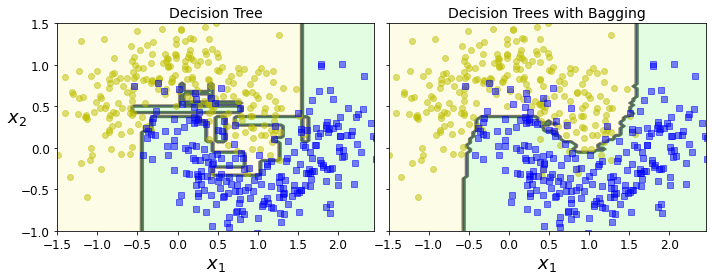

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

#### 배깅이 페이스팅보다 편향이 조금 더 높음(부트스트래핑이 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로). 하지만 이는 예측기들의 상관관계를 줄이기 때문에 앙상블의 분산을 감소시킴(보통은 배깅이 더 나음)

- 편향은 학습 알고리즘에서 잘못된 가정을 했을 때 발생하는 오차이다. 높은 편향값은 알고리즘이 데이터의 특징과 결과물과의 적절한 관계를 놓치게 만드는 과소적합(underfitting) 문제를 발생 시킨다.

- 분산은 트레이닝 셋에 내재된 작은 변동(fluctuation) 때문에 발생하는 오차이다. 높은 분산값은 큰 노이즈까지 모델링에 포함시키는 과적합(overfitting) 문제를 발생 시킨다.


# 7.2.2 oob(out-of-bag) 평가

In [18]:
# 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음
# BaggingClassifier는 기본적으로 중복을 허용하여 훈련 셋의 크기 만큼인 m개의 샘플을 선택함
# -> 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미
# m개의 샘플을 무작위로 추출할 때 선택되지 않을 확률 = (1 - 1/m)^m -> 0.3679로 수렴(아래 코드) -> 1 - 0.37 = 0.63

# 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag) 샘플이라고 함
# 따라서 검증 셋이나 교차 검증을 사용하지 않고 obb 샘플로 평가할 수 있음 -> 앙상블의 평가는 각 예측기의 obb 평가를 평균하여 얻음

In [19]:
m = 1000000000000
(1 - 1/m) ** m

0.36788757938730976

In [20]:
# 사이킷런에서 BaggingClassifier를 만들 때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [21]:
bag_clf.oob_decision_function_
# 예) oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 67.7%, 음성 클래스에 속할 확률을 32.3%로 추정하고 있음

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [22]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# 7.3 랜덤 패치와 랜덤 서브스페이스

### BaggingClassifier는 '특성' 샘플링도 지원 -> max_features, bootstrap_features 두 매개변수로 조절(max_samples, bootstrap과 동일하지만 샘플이 아니고 '특성'에 대한 샘플링) -> 따라서 각 예측기는 '무작위로 선택한 입력 특성의 일부분'으로 훈련됨


#### 랜덤 패치 방식(Random Patches method)
- 훈련 특성과 샘플을 모두 샘플링하는 것

#### 랜덤 서브스페이스 방식(Random Subspaces method)
- 훈련 샘플을 모두 사용하고(bootstrap=False, max_samples=1.0)
- 특성은 샘플링하는 것(bootstrap_features=True, max_features=1.0)

#### 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤

# 7.4 랜덤 포레스트

In [23]:
# 랜덤 포레스트: 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블

# 최대 16개의 리프 노드를 갖는 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드

from sklearn.ensemble import RandomForestClassifier

# RandomClassifier 사용
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [24]:
# BaggingClassfier에 DecisionTreeClassifier를 넣어서 사용
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [25]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [26]:
np.sum(y_pred == y_pred_rf) / len(y_pred)
# y_pred[i]와 y_pred_rf[i]가 같으면 1씩 증가 -> 그걸 y_pred의 총 개수로 나눴더니 1이 나옴 -> y_pred와 y_pred_rf가 똑같구나
# RandomClassifier 사용하든 BaggingClassfier에 DecisionTreeClassifier를 넣어서 사용하든 똑같구나

1.0

In [27]:
print(y_pred_rf)

[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0]


In [28]:
print(y_pred)

[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0]


# 7.4.1 엑스트라 트리

In [29]:
# 랜덤 포레스트 알고리즘은 무작위성을 더 주입하기 위해
# 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신
# 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 함
# (최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 뒤 그중에서 최상의 분할을 선택함)
# -> 편향이 늘어나지만 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄

# '극단적으로' 무작위한 트리의 랜덤 포레스트: 익스트림 랜덤 트리(Extremely Randomized Trees, 줄여서 엑스트라 트리) 앙상블이라고 함
# 마찬가지로 편향이 늘어나지만 분산을 낮춤

# 모든 노드에서 특성마다 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 오래 걸리는 작업 중 하나임
# -> 일반 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르겠지
# -> 누가 더 나은지는 모름, 둘 다 써보고 교차 검증으로 비교해보고 그리드 탐색으로 하이퍼파라미터 튜닝

# from sklearn.ensemble import ExtraTreesClassifier

# 7.4.2 특성 중요도

In [30]:
# 결정 트리 기반 모델은 모두 특성 중요도를 제공함
# 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함
# -> 더 정확하게 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음


# iris 데이터셋에 randomforest를 훈련시키고 각 특성의 중요도 출력
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [31]:
# 위 값들이 저장되어 있는 변수 feature_importances_
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

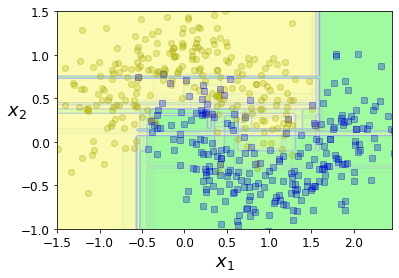

In [32]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

# 아래 그림처럼 15개의 decision tree의 결정 경계(decision boundary)가 불완전할지라도 앙상블은 꽤나 괜찮은 결정 경계를 만듦

In [33]:
# MNIST 데이터셋에 랜덤 포레스트 분류기 훈련시키고 각 픽셀의 중요도를 그래프로 나타낸 것

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [34]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [35]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


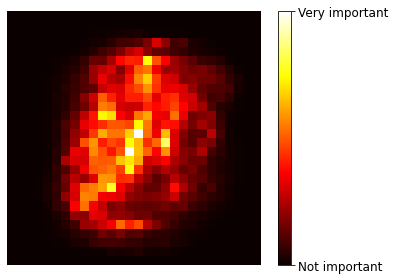

In [36]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# 7.5 부스팅(boosting)

### 부스팅
- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 부스팅 방법의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
- 가장 인기 있는 것은 아다부스트(AdaBoost, Adaptive Boosting)와 그래디언트 부스팅(Gradient Boosting)

# 7.5.1 아다부스트

#### 아다부스트: 이전 모델에서 과소적합(training error가 큰, 오분류한)했던 훈련 샘플의 선택 확률(가중치)을 더 높임(이전 예측기를 보완하는 새로운 예측기를 만들기 위해)

### 아다부스트 분류기
- 기반이 되는 첫 번째 분류기를 훈련 셋에서 훈련시키고 예측 -> 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임 -> 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 셋에서 훈련하고 다시 예측을 만듦 -> 반복...


In [37]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, # 200개의 아주 얕은 결정 트리(depth=1)
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

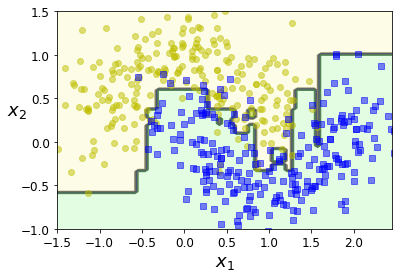

In [38]:
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


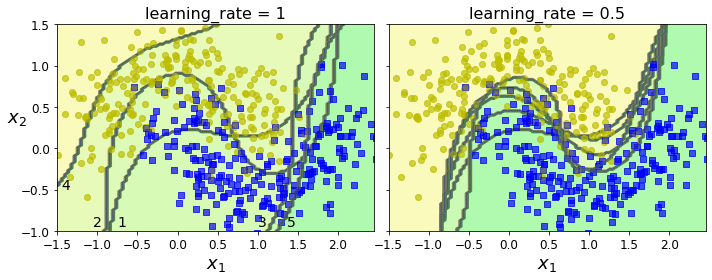

In [39]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

# 왼쪽 그래프: 1번 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아짐 -> 따라서 2번 분류기는 이 샘플들을 더 정확히 예측하게 함

# 이런 연속된 학습 기법은 경사 하강법과 비슷한 면이 있음
# 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면
# 아다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가함

# 이런 연속된 학습 기법의 단점: 이전 예측기가 훈련되고 평가된 후에 다음 예측기가 학습될 수 있기 때문에 병렬화가 안됨(확장성 낮음)

### 아다부스트 알고리즘
1. 모든 데이터(n개)의 가중치가 1/n -> 모두 동일하게 가중치 줌

2. for j = 1 to m (m: number of classifiers)
    - step 1. Find $h_j(x)$ that minimizes $L_j$ (weighted loss function)
        - ## $L_j = (\sum_{i=1}^nw_i * I(y_i != h_j(x))) \over \sum_{i=1}^nw_i$ ##
        - $L_j$: Loss Function
        - $w_i$: weight
        - $I()$: Indicate function(지시 함수: 특정 값이 집합에 속한다면 1, 속하지 않는다면 0의 값을 가진다.)
        - $y_i$: 답
        - $h_j()$: 모델
        - $h_j(x)$: 모델로 예측한 값
    - step 2. Define the weight of a classifier
    - ## $α_j = log{1 - L_j \over L_j}$ ##
    
    - step 3. Update weight
        - ## $w_i <-  w_i * e^{α_j * I(y_i != h_j(x))}, i = 1, 2, ... , n$ ##
    
3. Final boosted model
    - ## $h(x) = sign[\sum_{i=1}^nα_j * h_j(x)]$ ##

## 예시)

1. $n=10$, 각 데이터의 가중치는 $1\over10$이겠지, 첫 번째 분류에서 3개를 잘못 분류함

2. $j=1$일 때
    - step 1. 
    ### $ L_1 = {0.1*3\over0.1*n} = 0.3$ (10개 중 3개 오분류) ###
    
    - step 2.
    ### $ α_1 = log{1-0.3\over0.3} = 0.37$ ###
    
    - step 3.
    ### $w_c = 0.1*e^{0.37*0} = 0.1$ (정분류 관측치의 가중치)###
    ### $w_nc = 0.1*e^{0.37*1} = 0.14$ (오분류 관측치의 가중치)###
    
    ## 정분류 데이터의 가중치는 그대로 0.1, 오분류 데이터의 가중치는 0.14로 변함(증가함)(틀린 애들을 강조해서 다음에 더 잘 보겠다는 의미) ##
    
    ### $j=2$로 진행 -> 반복 ###
    
### 결국 $ α_1, h_1(x), α_2, h_2(x), α_3, h_3(x), ...$ 나옴 -> 다 합쳐서 최종 아다부스트 모델 완성(Sequential) ###

# 7.5.2 그래디언트 부스팅(Gradient Boosting)

In [40]:
# 그래디언트 부스팅은 아다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함
# 하지만 아다부스트처럼 반복마다 샘플의 가중치를 수정하지 않고 이전 예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습시킴

In [41]:
# 그래디언트 트리 부스팅(Gradient Tree Boosting), 그래디언트 부스티드 회귀 트리(Gradient Boosted Regression Tree, GBRT)

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100) # 잡음이 섞인 2차 곡선 형태의 훈련 셋

In [42]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y) # 첫 번째 예측기(decision tree regressor)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [43]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2) # 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 decision tree regressor 훈련시키기

DecisionTreeRegressor(max_depth=2, random_state=42)

In [44]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3) # 두 번째 예측기에서 생긴 잔여 오차에 세 번째 decision tree regressor 훈련시키기

DecisionTreeRegressor(max_depth=2, random_state=42)

In [45]:
X_new = np.array([[0.8]])

In [46]:
# 이제 세 개의 트리를 포함하는 앙상블 모델이 생김 -> 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됨
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [47]:
y_pred

array([0.75026781])

In [48]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


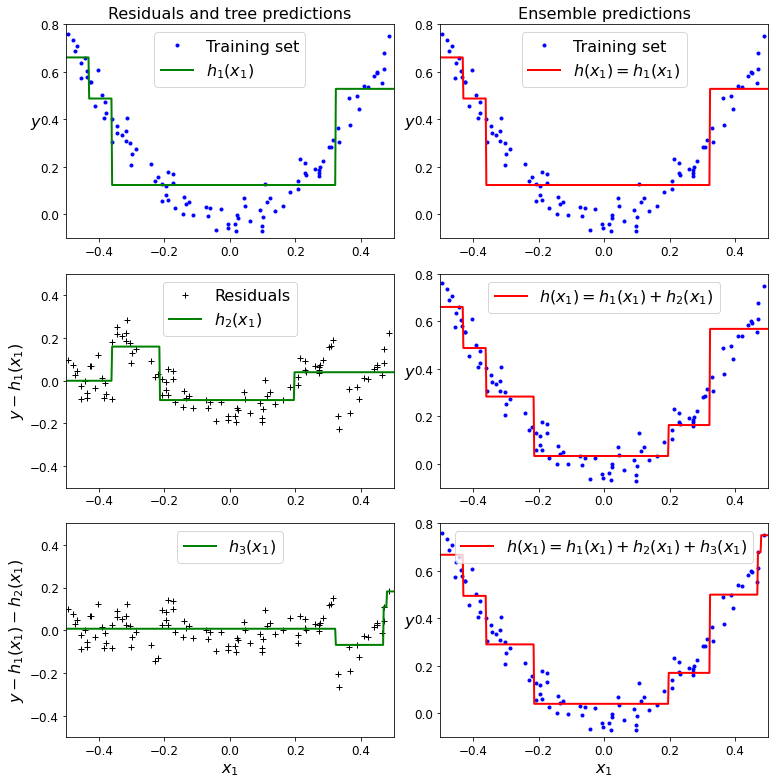

In [49]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

# 왼쪽 열은 세 결정 트리의 예측, 오른쪽 열은 앙상블의 예측
# 첫 번째 결정 트리 = 첫 번째 앙상블 모델
# 두 번째 결정 트리 = 첫 번째 결정 트리의 잔여 오차에 대해 학습
# 두 번째 앙상블 모델 = 첫 번째 결정 트리 + 두 번째 결정 트리

In [50]:
# 위에서 진행한 것과 같은 앙상블을 만드는 코드
from sklearn.ensemble import GradientBoostingRegressor # GBRT

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
# learning_rate 매개변수: 각 트리의 기여 정도를 조절
# -> 0.1처럼 낮게 설정하면 앙상블을 훈련 셋에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐
# 이를 축소(shrinkage)라고 함(규제 방법임)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [60]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [64]:
gbrt_slow2 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt_slow2.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=42)

Saving figure gbrt_learning_rate_plot


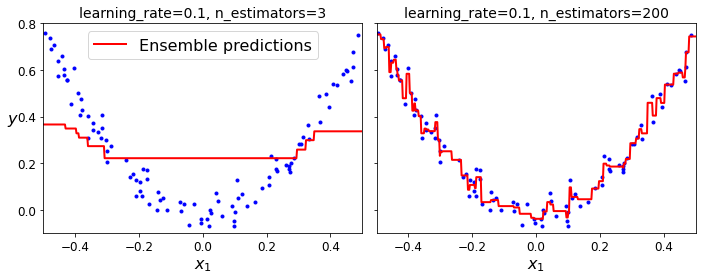

In [65]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt_slow2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow2.learning_rate, gbrt_slow2.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

# 왼쪽, 오른쪽 그래프는 learning_rate=0.1로 규제
# 왼쪽은 훈련 셋을 학습시키기에 트리가 충분하지 않음
# 오른쪽은 트리가 너무 많아서 훈련 셋에 과대적합됨

#### Gradient Boostin with Early stopping:

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)] # 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있음
# 간단하게 구현하려면 staged_predict() 메서드 사용
# 이 메서드는 훈련의 각 단계(각 트리)에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자(iterator)를 반환
# 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기 위해 살펴보는 방식
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

# 위 코드는 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정
# 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킴

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [54]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


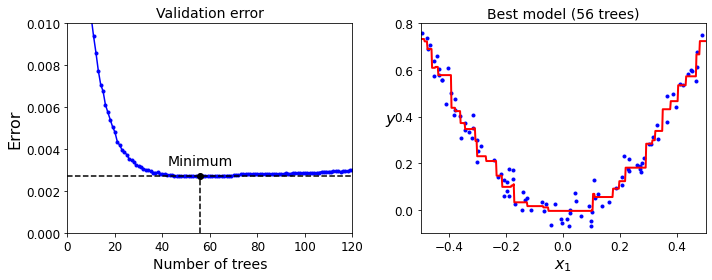

In [55]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

# 왼쪽: 검증 오차 / 오른쪽: 최적 모델의 예측
# 위 모델은 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기 위해 살펴보는 방식
# 위 방법 대신 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수도 있음(warm_start=True)

In [66]:
# 아래 코드는 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)
# subsample 매개변수로 각 트리가 사용할 훈련 샘플의 비율을 지정할 수 있음(subsample=0.25면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨)
# 편향이 높아지는 대신 분산이 낮아지게 됨, 훈련 속도 빨라짐
# 이런 기법을 확률적 그래디언트 부스팅(Stochastic Gradient Boosting)이라고 함

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [67]:
print(gbrt.n_estimators) # 최적의 트리 수

61


In [68]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


# 7.6 스태킹(stacking, stacked generalization)

### 아이디어: 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표 같은)를 사용하는 대신 '취합하는 모델을 훈련'시킬 수 없을까요?


![](./images/stacking.png)

### 아래 세 예측기는 각각 3.1, 2.7, 2.9를 예측하고 마지막 예측기(블렌더, blender 또는 메타 학습기, meta learner)가 이 예측을 입력으로 받아 최종 예측 3.0을 만듦

![](./images/stacking2.png)
### 블렌더를 학습시키는 일반적인 방법은 홀드 아웃(hold-out) 셋을 사용하는 것

- 주어진 원천 데이터를 랜덤(random)하게 두 분류로 분리하여 교차 검정을 실시하는 방법입니다. 하나는 모형의 학습 및 구축을 위한 훈련용 데이터로 하나는 성과 평가를 위한 검증용 데이터로 사용합니다.

### 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용

![](./images/stacking3.png)

### 다음으로 첫 번째 레이어의 예측기를 사용해 두 번째(홀드 아웃) 셋에 대한 예측을 만듦

### 예측기들이 훈련하는 동안 이 샘플(test set)들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전 새로운 것이겠지

### 이 새로운 예측을 입력 특성으로 사용하는 새로운 훈련 셋이 만들어짐(타깃값(답)은 그대로) -> 블렌더가 이 새로운 훈련 셋으로 훈련됨

![](./images/stacking4.png)

### 이런 방식의 블렌더를 여러 개 훈련시키는 것도 가능(예를 들어 하나는 선형 회귀, 하나는 랜덤 포레스트 회귀 등등)

### 그럼 블렌더만의 레이어가 만들어짐 -> 이렇게 하면 훈련 셋을 세 개의 서브셋으로 나눔

### 각 셋은 각 레이어를 훈련시키는 데에 사용됨

### 작업이 끝나면 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만듦
